<a href="https://colab.research.google.com/github/CristianAlegreBustos/ML--Tree-Classification/blob/main/Good_Starter_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#House Price Prediction Analysis

##Introduction

Reddic Housing LLC is a company that prodives housing price estimates to development firms. Recently, due to market competition and inovation, the company has decided to use machine learning and artificial intelligence to remain competative and provide quality, accurate, and effective price estimates. It is important that the company ensures customers can be confident in the price estimates.  

Using machine learning techniques like feature engineering, gradent boosted algorithms, and others, we have a model that can predict housing prices based on a number of features and it comes with a confidence metric that will satisfy the customers’ desires. We believe that this model can be used for house price evaluation and prediction in the market. We also believe that it is unecessary to adjust the predicted prices based on the quality of the area the house is located, as the model takes those things into account.

##Methodology

First, we examined the dataset to understand what the data looked like. We checked for strange values, explored how different features were related to price, and created new helpful features — for example, geo_cluster_cat to group homes by their location on the map.

Then, we trained the model with Optuna. We identified the most important features for the model. We transformed the price using a logarithm (log), which helps the model handle very high prices better. We split the data into two groups: training and testing. Moreover, we used a method that ensures different areas (zip codes) are fairly represented in both groups. We also used a ML method called XGBoost, which is good at finding patterns in structured data. It builds many decision trees and combines them to make better.  

To get the best results, we used a tool called Optuna to automatically find the best model settings (called hyperparameters). This included how many trees to build, how deep they can be, learning speed, and settings to avoid overfitting. The model was tested many times using cross-validation to find the best combination.

Once the best model was ready, we used it to predict house prices on the test set. Since we used log(price) earlier, we had to convert the predictions back to normal prices using the exponential function. We measured how well the model did using these metrics: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), R² (Explained Variance). These results show the model works very well and explains most of the changes in price.

In the future we can look at the errors grouped by zipcode and geo_cluster to see where the model makes bigger mistakes. This could help us improve the model later, maybe by training different models for different areas or adding more data.

##Results

The results we found based on the feature importances of the model was that 5 distinct features influenced the price of the property. The grade of the property, the location, the living area space, and if it was a waterfront property. The grade was easily the most important feature to look at for determining the price of the property.  

The higher the grade, the higher the price on an exponential level. After this location played a big role in determining the price. We sorted the locations into geo clusters and provided a color coded map for reference on their location. After that we can say the more space you had the higher the value, as well as being a water front property made a noticiable impact on the cost.

--- Training Set Metrics ---
RMSE : 92,140
MAE : 53,886
R²: 0.935

--- Test Set Metrics ---
RMSE : 124,583
MAE : 66,457
R²: 0.897


##Discussion Responses

For this problem, we decided that this is a regression problem where we are predicting a continuous value. This led to our decision to use a gradient boosted regression model in order to predict the continuous price value for a home based on a set of features.

We also decided that two confidence metrics would be useful in this case: root mean squared error and the r-squared value. The root mean squared error puts the performance of the model at the same scale and in the same units as the target (price in dollars) making it easy for an executive or customer to understand. Moreover, as we built and tested many models, we used the r-squared value to guage the predictive power, and make improvements.  

When faced with the question of whether we should identify properties in low income areas and have the model lower those estimates to protect our insurance customers’ interests, we observed that our model already adjusted for those things based on the features that it used to predict the price. Moreover, we felt a little bit uncomfortable ethically about doing something like this.

Lastly, we noticed that the features all have varying ranges and scales and we had to consider how to deal with that. After further analysis, we learned that the gradient boosted tree is not affected by large ranges on its input. We even tried to scale the inputs, and noticed extremely little to no improvement. Thus, we decided to give the model the data as is without scaling.

In [44]:
!pip install scikit-learn==1.5.2
!pip install optuna

In [45]:
# Import the libraries we need
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing  import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [46]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

In [47]:
# drop missign values
housing=housing.dropna()

In [48]:
housing['price'].describe()

,price
count,2.000000e+04
mean,5.394367e+05
std,3.664334e+05
min,7.500000e+04
25%,3.220000e+05
50%,4.500000e+05
75%,6.416250e+05
max,7.700000e+06


In [49]:
# EncoderZipcode
encoder = LabelEncoder()
housing['zipcode'] = encoder.fit_transform(housing[['zipcode']])

# House_Age
housing['house_age'] = 2025 - housing['yr_built']

# Renovation indicator
housing['was_renovated'] = (housing['yr_renovated'] > 0).astype(int)

# Relación entre área habitable y tamaño del terreno
# Relationship between living area and lot are
housing['living_to_lot_ratio'] = housing['sqft_living'] / housing['sqft_lot']

# Basement to living area ratio
housing['basement_ratio'] = housing['sqft_basement'] / housing['sqft_living']
housing['basement_ratio'] = housing['basement_ratio'].fillna(0)  # Manejo de división por cero

# Average room size
housing['avg_room_size'] = housing['sqft_living'] / housing['bedrooms']
housing['avg_room_size'] = housing['avg_room_size'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Premium Zone Indicator
housing['premium_zone'] = ((housing['waterfront'] == 1) | (housing['view'] >= 3)).astype(int)

# Multi floor indicator
housing['multi_floor'] = (housing['floors'] > 1).astype(int)

# Converting the date to datetime format
housing['date'] = pd.to_datetime(housing['date'])


#Sale Month
housing['sale_month'] = housing['date'].dt.month


# Year of the last renovation
housing['yrs_since_renov'] = housing['date'].dt.year - housing['yr_renovated']
housing.loc[housing['yr_renovated'] == 0, 'yrs_since_renov'] = -1  # Marcamos las no renovadas


# full vs half bathrooms
housing['full_baths'] = np.floor(housing['bathrooms']).astype(int)
housing['half_baths'] = ((housing['bathrooms'] % 1) >= 0.5).astype(int)


# Geographic cluster based on coordinates
km = KMeans(n_clusters=10, random_state=42)
housing['geo_cluster'] = km.fit_predict(housing[['lat', 'long']])

In [50]:
#Selected Features
selected_features = ['sqft_living','grade','sqft_above','sqft_living15','bathrooms','view','sqft_basement','lat','bedrooms','waterfront','floors','yr_renovated','sqft_lot','sqft_lot15','yr_built','condition','long','zipcode','geo_cluster',
    'house_age',
    'was_renovated',
    'living_to_lot_ratio',
    'basement_ratio',
    'avg_room_size',
    'premium_zone',
    'multi_floor',
    'sale_month',
    'yrs_since_renov',
    'full_baths',
    'half_baths',
                     ]

#Prediccion normal 'price'

In [51]:

X = housing[selected_features] #


y = housing['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model and train it, use default hyperparameters for now
model =  XGBRegressor( random_state=42)
model.fit(X_train, y_train)

# Get predictions for our test data
predictions = model.predict(X_test)
predictions
# Compute the Root Mean Squared Error of the predictions
from sklearn.metrics import root_mean_squared_error

result = root_mean_squared_error(y_test, predictions)
result

np.float64(135303.4372092671)

#Prediccion  log(price)

In [52]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# 1. Prepare data and split into train/test sets
X = housing[selected_features]
y_log = np.log(housing['price'])

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

def objective(trial):
    # 2. Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600, step=50), # Slightly increased max, good balance
    'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.15, log=True), # Broader range around previous best
    'max_depth': trial.suggest_int('max_depth', 4, 8), # Allow slightly deeper trees
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 20), # A more flexible range
    'gamma': trial.suggest_float('gamma', 0.1, 2.0, log=True), # Less aggressive lower bound for gamma
    'subsample': trial.suggest_float('subsample', 0.7, 1.0), # Keep this range
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # Keep this range
    'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True), # Allow smaller alpha but still strong
    'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 10.0, log=True), # Allow smaller lambda but still strong
    'random_state': 42,
    'tree_method': 'hist',
    'verbosity': 0
    }

    # 3. K-Fold cross-validation on log-scale using only the training data
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    model = XGBRegressor(**params)

    # We'll do CV on the log-target of the training data, then convert back to price to compute RMSE:
    rmses = []
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_va = y_train_log.iloc[train_idx], y_train_log.iloc[valid_idx]
        model.fit(X_tr, y_tr)

        # Predict log-price, invert log
        log_preds = model.predict(X_va)
        preds     = np.exp(log_preds)
        true_vals = np.exp(y_va)

        rmse = np.sqrt(mean_squared_error(true_vals, preds))
        rmses.append(rmse)

    # 4. Return the mean RMSE across folds
    return float(np.mean(rmses))

# 5. Run the study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, timeout=600)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

# 6. Train final model on full training set using best_params
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train_log)

# 7. Predict with log scale on the test set
log_preds = best_model.predict(X_test)

#    Convert log predictions back to original scale
preds = np.exp(log_preds)

# 8. Convert the real y_test (which is already in log scale) back to original scale
y_test = np.exp(y_test_log)

# 9. Compute metrics in the original scale
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)

print(f"RMSE : {rmse:,.0f}")
print(f"MAE : {mae:,.0f}")
print(f"R²: {r2:.3f}")

[I 2025-06-28 17:58:28,880] A new study created in memory with name: no-name-5084c2dc-ef20-4d9a-859f-279dd7239d2f
[I 2025-06-28 17:58:56,991] Trial 0 finished with value: 129641.94736116445 and parameters: {'n_estimators': 350, 'learning_rate': 0.1358198535217987, 'max_depth': 7, 'min_child_weight': 14, 'gamma': 0.1595823775294975, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 5.3994844097874335, 'reg_lambda': 3.027182927734624}. Best is trial 0 with value: 129641.94736116445.
[I 2025-06-28 17:59:24,035] Trial 1 finished with value: 119459.1471802162 and parameters: {'n_estimators': 500, 'learning_rate': 0.020846957895078073, 'max_depth': 8, 'min_child_weight': 18, 'gamma': 0.18891200276189393, 'subsample': 0.7545474901621302, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.4059611610484306, 'reg_lambda': 2.4082072654535422}. Best is trial 1 with value: 119459.1471802162.
[I 2025-06-28 17:59:38,857] Trial 2 finished with value: 127749.6680

Best RMSE: 114996.64461225658
Best params: {'n_estimators': 600, 'learning_rate': 0.1419067500542417, 'max_depth': 5, 'min_child_weight': 20, 'gamma': 0.10617790273943419, 'subsample': 0.7937866809962186, 'colsample_bytree': 0.8158480427211191, 'reg_alpha': 0.17462067813186458, 'reg_lambda': 1.5341676807705107}
RMSE : 124,583
MAE : 66,457
R²: 0.897


In [53]:
# 1) Prepara X y y_log before split
X = housing[selected_features]
y_log = np.log(housing['price'])

# 2) Split  train/test
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 3) Train the model with y_train_log
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train_log)

# 4) Predic log scale
log_preds = model.predict(X_test)

#    return the log in usd
preds = np.exp(log_preds)

# 5) Remade the real price of y_test
y_test = np.exp(y_test_log)

# Compute the Root Mean Squared Error of the predictions
result = root_mean_squared_error(y_test , preds)
result

np.float64(132125.29421754705)

In [54]:
# prompt: evalua si esta overfitenado comparandoo las metricas de test con train

# Get predictions for the training set
train_log_preds = best_model.predict(X_train)

# Convert training log predictions back to original scale
train_preds = np.exp(train_log_preds)

# Convert the real y_train (which is already in log scale) back to original scale
y_train = np.exp(y_train_log)

# Compute metrics on the training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_mae  = mean_absolute_error(y_train, train_preds)
train_r2   = r2_score(y_train, train_preds)

print("\n--- Training Set Metrics ---")
print(f"RMSE : {train_rmse:,.0f}")
print(f"MAE : {train_mae:,.0f}")
print(f"R²: {train_r2:.3f}")

print("\n--- Test Set Metrics ---")
print(f"RMSE : {rmse:,.0f}")
print(f"MAE : {mae:,.0f}")
print(f"R²: {r2:.3f}")

# Compare the metrics
print("\n--- Overfitting Analysis ---")
if train_rmse < rmse:
    print("The model might be overfitting. Training RMSE is lower than Test RMSE.")
elif train_rmse > rmse:
     print("The model might be underfitting. Training RMSE is higher than Test RMSE.")
else:
    print("Training and Test RMSE are similar, which is generally good.")

if train_r2 > r2:
    print("The model might be overfitting. Training R-squared is higher than Test R-squared.")
elif train_r2 < r2:
    print("The model might be underfitting. Training R-squared is lower than Test R-squared.")
else:
    print("Training and Test R-squared are similar, which is generally good.")

# A significant difference between training and test metrics (e.g., train metrics being much better)
# suggests overfitting. Similar metrics suggest a good generalization to unseen data.


--- Training Set Metrics ---
RMSE : 92,140
MAE : 53,886
R²: 0.935

--- Test Set Metrics ---
RMSE : 124,583
MAE : 66,457
R²: 0.897

--- Overfitting Analysis ---
The model might be overfitting. Training RMSE is lower than Test RMSE.
The model might be overfitting. Training R-squared is higher than Test R-squared.


Top 15 features reduce errors on tree

Top 15 features por importancia:
 grade            0.345088
sqft_living      0.175673
lat              0.105652
sqft_above       0.046911
premium_zone     0.045373
sqft_living15    0.044734
view             0.041711
waterfront       0.027347
bathrooms        0.021219
sqft_basement    0.015133
long             0.014055
yr_built         0.013694
geo_cluster      0.012633
condition        0.010427
sqft_lot15       0.009047
dtype: float32


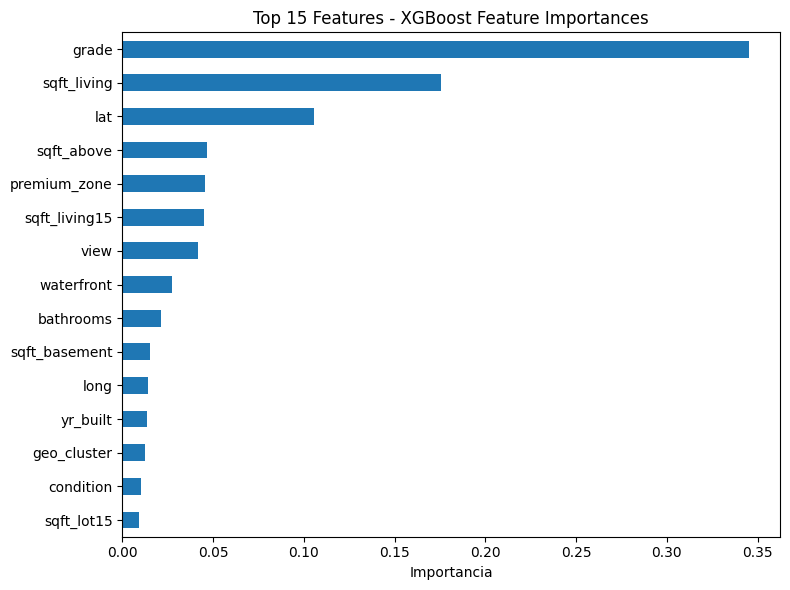

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer importancias
importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

# Mostrar las 15 top features
print("Top 15 features por importancia:\n", importances.head(15))

# Gráfico horizontal
plt.figure(figsize=(8,6))
importances.head(15).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 15 Features - XGBoost Feature Importances")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


#Chequeo de Sesgos por Grupo (“Fairness Check”)

In [56]:
#1. Predicciones y valores reales en pesos
log_preds = best_model.predict(X_test)
preds    = np.exp(log_preds)
y_true   = np.exp(y_test_log)

# Residual = predicho - real
residuals = preds - y_true

In [57]:
#2 Asegúrate de tener ‘zipcode’ y ‘geo_cluster’ en X_test
test_df = X_test.copy()
test_df['price_true']  = y_true
test_df['price_pred']  = preds
test_df['residual']    = residuals

In [58]:
#3 Por zipcode
zip_stats = test_df.groupby('zipcode')['residual'] \
            .agg(['mean','median','std','count']) \
            .sort_values('mean')
print("Error medio por zipcode:\n", zip_stats.head(10))

#4 Por cluster geográfico
cluster_stats = test_df.groupby('geo_cluster')['residual'] \
                 .agg(['mean','median','std','count']) \
                 .sort_values('mean')
print("\nError medio por geo_cluster:\n", cluster_stats.head(10))

Error medio por zipcode:
                   mean         median            std  count
zipcode                                                    
24      -326202.656250 -328111.687500  153841.050348      6
3       -111090.963294  -43571.937500  454450.312847     63
25       -97575.720982  -86750.437500  185174.844315     56
47       -67678.847222  -14124.625000  262241.919220     18
41       -57407.416667  -24261.546875  155121.141086     18
21       -38682.865461  -16633.187500  166374.672321     95
60       -36971.346311  -19661.812500   84191.419085     61
5        -35703.455556   -8939.500000  291114.985496     90
7        -30719.737723    3030.656250  186342.928848     56
63       -29379.270000  -23226.062500   88940.746796     50

Error medio por geo_cluster:
                      mean       median            std  count
geo_cluster                                                 
0           -26174.195975 -6224.546875  203884.537704    472
6           -21971.337992 -7268.953125  

<Figure size 24000x12800 with 0 Axes>

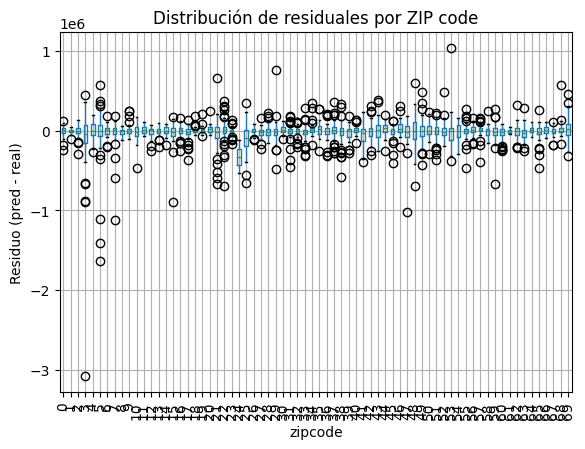

In [59]:
#4 Boxplot de residuales por zipcode (ten cuidado si hay muchos códigos)
plt.figure(figsize=(240,128))
test_df.boxplot(column='residual', by='zipcode', rot=90)
plt.title("Distribución de residuales por ZIP code")
plt.suptitle("")
plt.ylabel("Residuo (pred - real)")
plt.show()